# Get QC metrics and Annotation using CSM (SRM 1950 datasets)

Output includes 
```'Total features',
    'SNR > 5',
    'cSelectivity > 0.9',
    'Emprical compounds',
    '12/13C paired empCpds',
    'Singletons',
    'CSM matched',
    'CSM_BMDB matched', 
    'Mandal_BMDB matched',
```

Also CSM annotation in tsv file, two QC plot figures, and the stats in JSON.

One can further extract expt wide metrics from each feature table, e.g. CV of features, 
intensity correlation of common features.

The compounds reported by Mandal et al (2025) on NIST SRM 1950 are used here to compare annotation. 
The report contains 922 HMDB entries, but we focus on 706 compounds that are in CSM BMDB. 

To use this notebook, one needs the utils modules from CSM GitHub repo and relevant DB files (details in code blocks 2 and 3).

Shuzhao Li, 2025-10-09

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# install asari if needed
from mass2chem.search import (build_centurion_tree,
                        find_all_matches_centurion_indexed_list)
from asari.mass_functions import complete_mass_paired_mapping

In [2]:
# CSM utils modules
# same files from GitHub repo, https://github.com/shuzhao-li-lab/consensus_serum_metabolome/tree/main/utils
sys.path.append("/Users/lish/li.github/consensus_serum_metabolome/utils")
from mining import *
from csm_align import *
from khipu_custom import *

In [3]:
# CSM database files, download from https://github.com/shuzhao-li-lab/consensus_serum_metabolome/releases/download/v1.6.2/r1_libs_1.6.2.zip
# place the files under this directory
DBFILES_DIR = '/Users/lish/li.proj/NIST_collaborative/DB_REF_CSM/'

# Load CSM data
BMDB = json.load(open(DBFILES_DIR + 'blood_metabolites_20250212.json'))
bmDict = {}
for x in BMDB: bmDict[x['id']] = x

neuCSM = json.load(open(DBFILES_DIR + 'r1_neu_mass_registries_annotated_1012.json'))
lib_hilicpos = json.load(open(DBFILES_DIR + 'r1_ref_hilic_pos_csmfs_20250304.json'))
lib_rppos = json.load(open(DBFILES_DIR + 'r1_ref_rp_pos_csmfs_20250304.json'))
lib_hilicneg = json.load(open(DBFILES_DIR + 'r1_ref_hilic_neg_csmfs_20250304.json'))
lib_rpneg = json.load(open(DBFILES_DIR + 'r1_ref_rp_neg_csmfs_20250304.json'))

# load Wishart lab annotation on SRM 1950
# This is agreement btw CSM and Wishart data; 706 out HMDB 922 entries
srm_hmdb_subset706 = json.load(open(DBFILES_DIR + 'Wishart2025_SRM1950_bmDBoverlap706.json'))

In [4]:
# check data formats
bmDict['MDB0000375r1'], srm_hmdb_subset706['MDB0000830r1']

({'inchikey': 'HPNSFSBZBAHARI-RUDMXATFSA-N',
  'name': 'Mycophenolic acid',
  'chemical_formula': 'C17H20O6',
  'xlogP': 3.2,
  'BloodPaperCount': 2344,
  'smiles': 'COC1=C(C\\C=C(/C)CCC(O)=O)C(O)=C2C(=O)OCC2=C1C',
  'accession': 'HMDB0015159',
  'logp': 3.53,
  'kingdom': 'Organic compounds',
  'super_class': 'Organoheterocyclic compounds',
  'class': 'Isocoumarans',
  'sub_class': 'Isobenzofuranones',
  'blood_conc': None,
  'id': 'MDB0000375r1',
  'monoisotopic_molecular_weight': 320.125988372,
  'RTI_RP_NORMAN': 624.87},
 {'inchikey': 'KFZMGEQAYNKOFK-UHFFFAOYSA-N',
  'name': 'Isopropyl alcohol',
  'chemical_formula': 'C3H8O',
  'xlogP': 0.3,
  'BloodPaperCount': 1099,
  'smiles': 'CC(C)O',
  'accession': 'HMDB0000863',
  'logp': 0.25,
  'kingdom': 'Organic compounds',
  'super_class': 'Organic oxygen compounds',
  'class': 'Organooxygen compounds',
  'sub_class': 'Alcohols and polyols',
  'blood_conc': 109.05,
  'id': 'MDB0000830r1',
  'monoisotopic_molecular_weight': 60.057514878,

In [5]:
# Batch processing functions
primary_ions = primary_ions_neg.union(primary_ions_pos)
KCD_formula_coordinate = build_KCD_from_formula_coordinate(formula_coordinate)
csmlib_dict = {
    'hilicpos': lib_hilicpos,
    'rppos': lib_rppos,
    'hilicneg': lib_hilicneg,
    'rpneg': lib_rpneg
}

def annotate3_asari_table_by_csm(
                        asari_table, 
                        KCD_formula_coordinate, 
                        isotope_search_patterns,
                        adduct_search_patterns_pos,
                        extended_adducts,
                        mode = 'pos', method='rppos',
                        mz_tolerance_ppm=5, rt_tolerance=2,
                        bmDict=bmDict,
                        reflib=lib_rppos, 
                        neuDict=neuCSM,
                        outfile='csmf_anno__.tsv', 
                        sep='\t',
                        quality_filter=True
                        ):
    epdlist, list_features_ = run_khipu_insitu(asari_table,
                                KCD_formula_coordinate, 
                                isotope_search_patterns,
                                adduct_search_patterns_pos,
                                extended_adducts,
                                mode = mode,
                                mz_tolerance_ppm=mz_tolerance_ppm, 
                                rt_tolerance=rt_tolerance,)
    clean_dict_match, featureDict = csmf_annotate_from_epd_list(
            epdlist, reflib=reflib, 
            )
    anno, header = export_csmf_annotation(clean_dict_match, featureDict, bmDict=bmDict,
                                        reflib=reflib, 
                                        neuDict=neuDict,
                                        )
    # keep quality features only
    if quality_filter:
            new = {}
            for k,v in anno.items():
                    if v['ion_csm'] in primary_ions:
                            new[k] = v
            anno = new
            
    return anno, header, epdlist, list_features_

def write3_anno_csmf_format(anno, header, outfile, sep='\t'):
    s = sep.join(header ) + '\n'
    s += '\n'.join(
        [sep.join([str(x[ii]) for ii in header]) for x in anno.values()]
    )
    with open(outfile, 'w') as O:
        O.write(s)
        
# These two functions find overlap with expected cpds 
def count_bmdb_ids(anno, BMDB_expected):
        '''specific to internal formats, using CSM BMDB IDs
        '''
        _c = 0
        for x in anno.values():
                mdb = [y[1] for y in x['top3'] if y[1] in BMDB_expected]
                if mdb:
                        _c += 1
        return _c
        
def count_expected_neumass(neu_mass_list, expected_list, ppm=5):
        '''By neutral mass matches. 
        '''
        L1 = neu_mass_list # [x['neutral_formula_mass'] for x in epdlist]
        L2 = [x['mono_mass'] for x in expected_list.values()]
        mapped, u1, u2 = complete_mass_paired_mapping(
                [x for x in L1 if x is not None],
                [x for x in L2 if x is not None],
                std_ppm=ppm)
        return len(mapped)


In [6]:
sns.set_theme(style="whitegrid")

def plot_qc_(list_features, title, vline_snr=np.log2(5), vline_csel=0.9, outfile="qc_plot.pdf"):
    '''
    list_features : list of JSON style dicts
    Plot asari QC metrics in a combined figure and save to a PDF file.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    log2snr = [np.log2(x['snr']) for x in list_features]
    csel = [float(x['cSelectivity']) for x in list_features]
    sns.kdeplot( data=log2snr,  ax=ax1, fill=True, alpha=.5, linewidth=3)
    ax1.axvline(x=vline_snr, color='red', linestyle='--',)
    ax1.set_xlabel("Log2 SNR")
    plt.title(title)
    
    sns.kdeplot( data=csel, ax=ax2, fill=True, alpha=.5, linewidth=3)
    ax2.axvline(x=vline_csel, color='red', linestyle='--',)
    ax2.set_xlabel("cSelectivity")
    
    plt.tight_layout()
    plt.savefig(outfile)
    
def barplot_stats(header, counts, title, out="bar.pdf"):
    fig, ax = plt.subplots(figsize=(6,3))
    bar_container = ax.barh(header, counts)
    ax.yaxis.set_inverted(True) 
    ax.set(xlabel='Count', title=title)
    ax.bar_label(bar_container, fmt='{:,.0f}')
    plt.tight_layout()
    plt.savefig(out)

def plot_missing_data_points(list_features, title, outfile="missing_data_plot.pdf"):
    '''
    missing_data : dict
    Plot missing data points in a bar chart and save to a PDF file.
    '''
    fig, ax = plt.subplots(figsize=(6, 3))
    tally = sorted([int(x['detection_counts']) for x in list_features], reverse=True)
    ax.plot(range(len(tally)), tally)
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Detection Count")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(outfile)

    

## Work on Asari processed data

Each folder from Asari output has a defined structure. We use `export/full_Feature_table.tsv` for pre-annotation, i.e., grouping redundant ions.

In [ ]:
# Data 
indir = './'
outdir = 'csm_dilutions_results/'  # Current dir or extant dir
_end_ = '/export/full_Feature_table.tsv'

# Need 2nd item as keyword to define method
list_infiles = [
    ('q_asari_project_109101128' + _end_, 'hilicpos'),
    ('q4_asari_project_10910127' + _end_, 'hilicpos'),
    ('q16_asari_project_109101243' + _end_, 'hilicpos'),
    ('q64_asari_project_109101319' + _end_, 'hilicpos'),
    ('q256_asari_project_109101355' + _end_, 'hilicpos'),
    ('q1024_asari_project_109101430' + _end_, 'hilicpos'),
]

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', 'MT_20211020_079', 'MT_20211020_001', 'MT_20211020_003', 'MT_20211020_083']
Read 5630 feature lines
Mass accuracy was estimated on 5272 matched values as -0.2 ppm.
No mz correction is needed.


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M+H+       Na/H      CH3OH        K/H        ACN     NaCOOH
M0         1.007276  22.989216  33.033491  38.963158  42.033825  68.994700
13C/12C    2.010631  23.992571  34.036846  39.966513  43.037180  69.998055
13C/12C*2  3.013986  24.995926  35.040201  40.969868  44.040535  71.001410
Constructed 956 khipus in this round.


Khipu search grid: 
                       M+H+, 2x charged  Na/H, 2x charged  CH3OH, 2x charged  \
M0                             0.503638         11.998246          17.020384   
13C/12C, 2x charged          

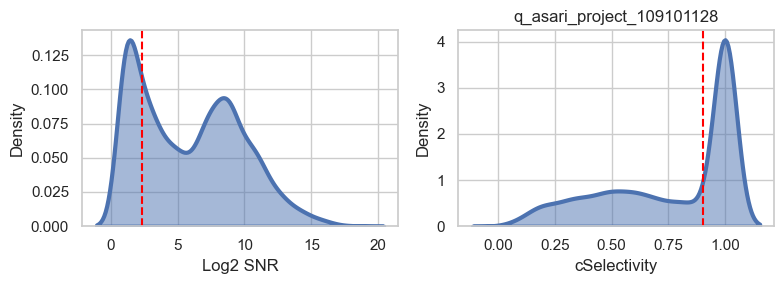

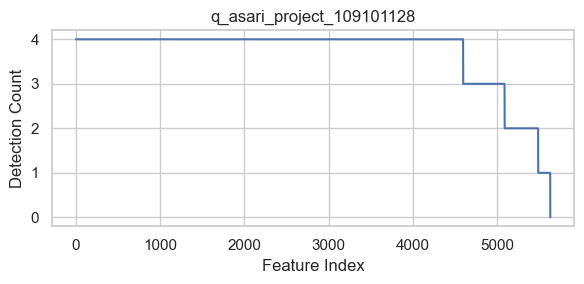

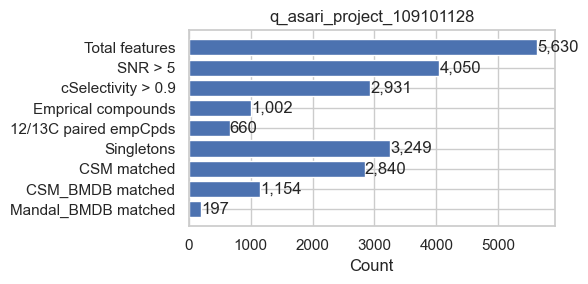

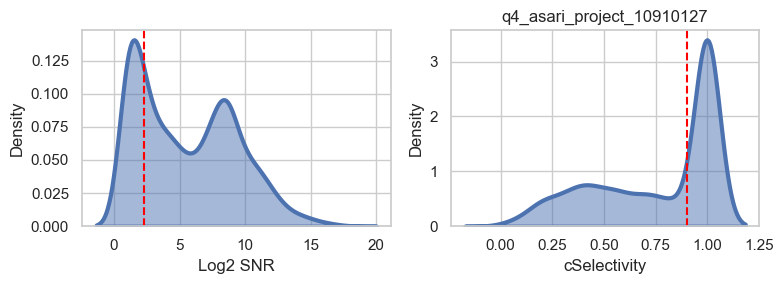

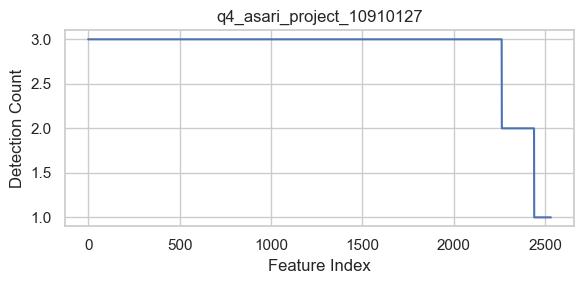

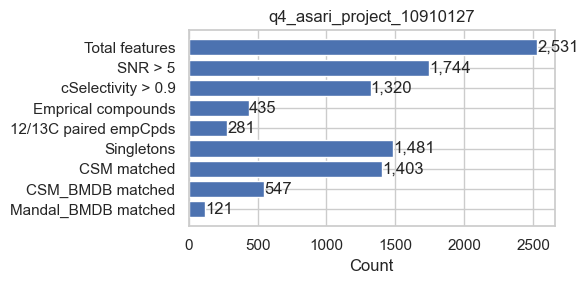

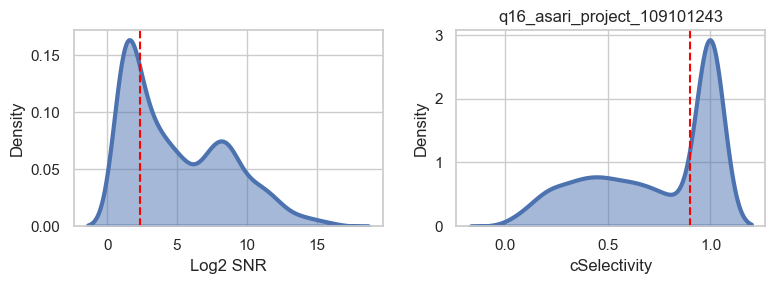

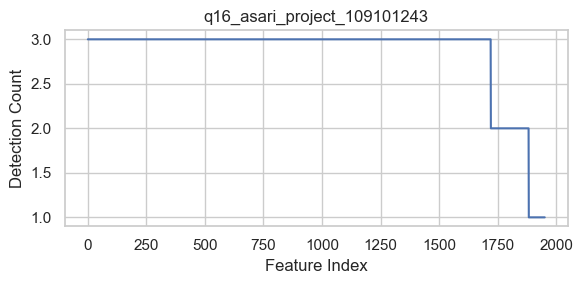

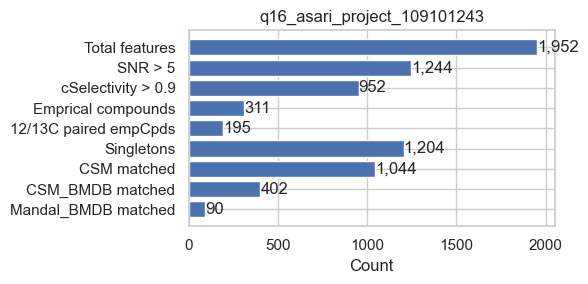

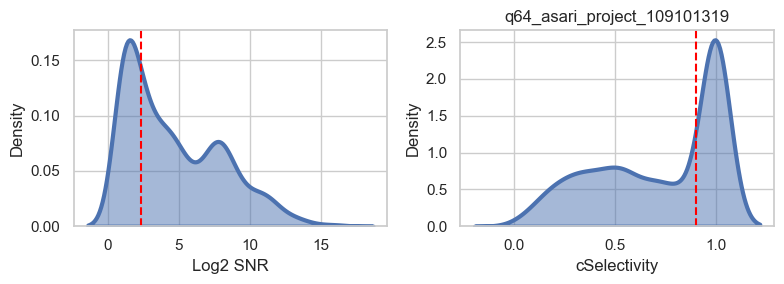

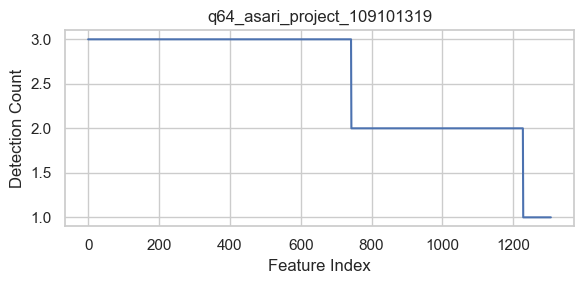

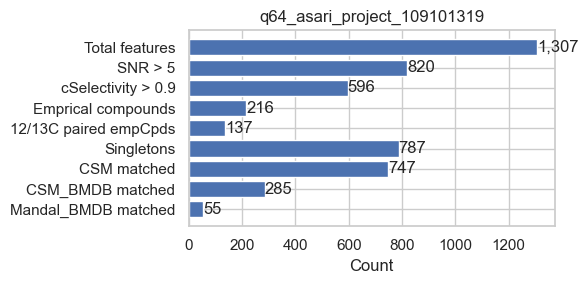

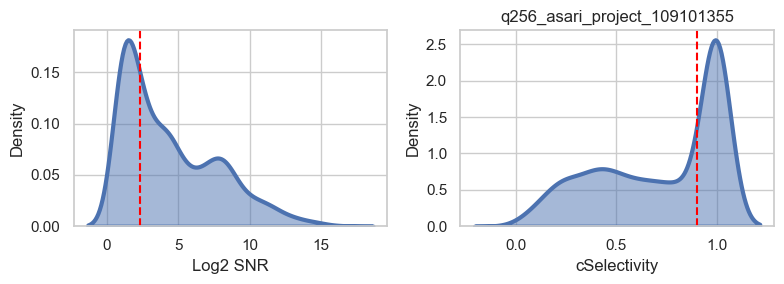

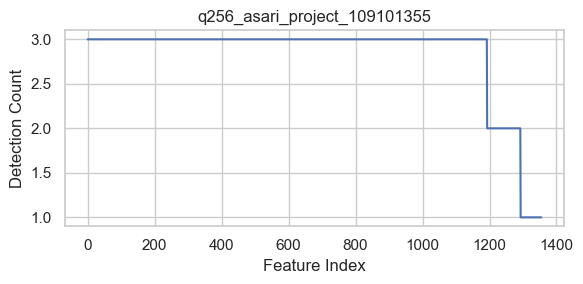

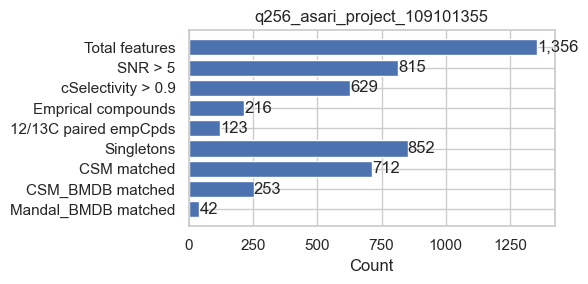

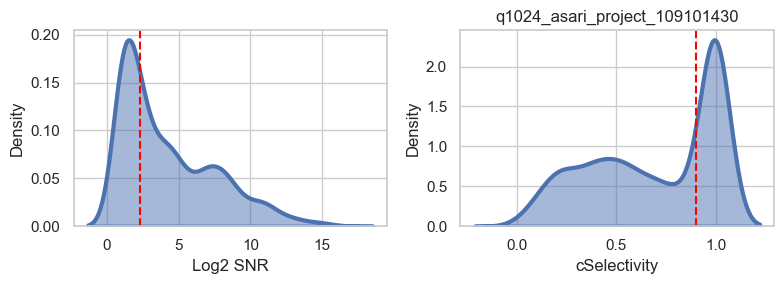

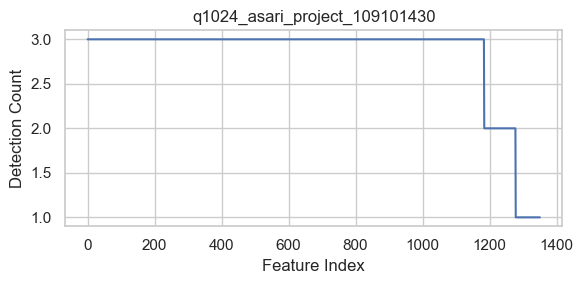

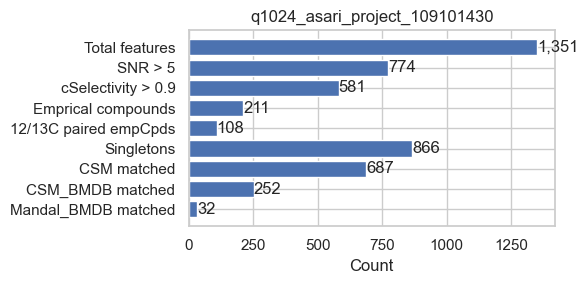

In [ ]:
stats_result = {}

for f, method in list_infiles:
    _fname_handle_ = os.path.split(f.replace('/export/full_Feature_table.tsv', ''))[1]
    outfile = outdir + 'csmf_anno_' + _fname_handle_ + '.tsv'

    mode='pos'
    adduct_search_patterns=adduct_search_patterns_pos
    # dict_member_size = pos_dict_member_size
    if 'neg' in method:
        mode = 'neg'
        adduct_search_patterns=adduct_search_patterns_neg
        # dict_member_size = neg_dict_member_size
    
    anno, header, epdlist, list_features = annotate3_asari_table_by_csm(
                        indir + f, 
                        KCD_formula_coordinate, 
                        isotope_search_patterns,
                        adduct_search_patterns,
                        extended_adducts,
                        # dict_member_size=dict_member_size,
                        mode = mode, 
                        # method=method,
                        mz_tolerance_ppm=5, rt_tolerance=2,
                        bmDict=bmDict,
                        reflib= csmlib_dict[method], 
                        neuDict=neuCSM,
                        outfile=outfile,
                        sep='\t',
                        quality_filter=False
    )
    write3_anno_csmf_format(anno, header, outfile)
    plot_qc_(list_features, _fname_handle_, outfile=outfile.replace('.tsv', '_qc.pdf'))

    plot_missing_data_points(list_features, _fname_handle_, outfile=outfile.replace('.tsv', '_missing_data.pdf'))
    
    # Not doing this now, as problems arise 1) getting neutral mass on singletons; dealing with isomers
    # CSM match is much better approach
    # neu_mass_list = [x['neuMR_ID'] for x in anno.values()]
    # neu_mass_list = [float(x.split('_')[2]) for x in set(neu_mass_list)]
    # Mandal2025_matched = count_expected_neumass(neu_mass_list, srm_hmdb922)
    
    # write stats per file
    num_features = len(list_features)
    num_good_features = len([f for f in list_features if f['snr']>5])
    num_csel_9 = len([f for f in list_features if float(f['cSelectivity'])>0.9])
    khipus = [p for p in epdlist if len(p['MS1_pseudo_Spectra'])>1]
    num_khipus = len(khipus)
    num_singletons = len(epdlist) - num_khipus
    isopair_empCpds = filter_khipus(khipus)  # not matching adducts here, but intensity used
    num_csm_matched = len(anno)
    num_bmdb_matched = len([x for x in anno.values() if x['top3']])
    Wishart_overlap = count_bmdb_ids(anno, srm_hmdb_subset706.keys())
    
    header = ['Total features',
                'SNR > 5',
                'cSelectivity > 0.9',
                'Emprical compounds',
                '12/13C paired empCpds',
                'Singletons',
                'CSM matched',
                'CSM_BMDB matched', 
                # 'Mandal2025 matched',
                'Mandal_BMDB matched',
                ]
    
    # match to header sequence
    this_counts = [num_features, num_good_features, num_csel_9, 
                   num_khipus, len(isopair_empCpds), num_singletons, 
                   num_csm_matched, num_bmdb_matched, 
                   # Mandal2025_matched, 
                   Wishart_overlap,
                 ]
    
    stats_result[_fname_handle_] = dict(zip(header, this_counts))
    barplot_stats(header, this_counts, _fname_handle_, out=outfile.replace('.tsv', '_barplot.pdf'))

    # Export stats
    with open(outfile.replace('.tsv', '_stats.json'), 'w') as O:
        json.dump(stats_result, O, indent=4)


In [9]:
len(list_infiles), stats_result

(6,
 {'q_asari_project_109101128': {'Total features': 5630,
   'SNR > 5': 4050,
   'cSelectivity > 0.9': 2931,
   'Emprical compounds': 1002,
   '12/13C paired empCpds': 660,
   'Singletons': 3249,
   'CSM matched': 2840,
   'CSM_BMDB matched': 1154,
   'Mandal_BMDB matched': 197},
  'q4_asari_project_10910127': {'Total features': 2531,
   'SNR > 5': 1744,
   'cSelectivity > 0.9': 1320,
   'Emprical compounds': 435,
   '12/13C paired empCpds': 281,
   'Singletons': 1481,
   'CSM matched': 1403,
   'CSM_BMDB matched': 547,
   'Mandal_BMDB matched': 121},
  'q16_asari_project_109101243': {'Total features': 1952,
   'SNR > 5': 1244,
   'cSelectivity > 0.9': 952,
   'Emprical compounds': 311,
   '12/13C paired empCpds': 195,
   'Singletons': 1204,
   'CSM matched': 1044,
   'CSM_BMDB matched': 402,
   'Mandal_BMDB matched': 90},
  'q64_asari_project_109101319': {'Total features': 1307,
   'SNR > 5': 820,
   'cSelectivity > 0.9': 596,
   'Emprical compounds': 216,
   '12/13C paired empCpds'

In [10]:
# export stats to tsv
s = 'dataset_id\t' + '\t'.join(header) + '\n'
for ST in stats_result:
    s += ST + '\t' + '\t'.join([str(stats_result[ST][x]) for x in header]) + '\n'
with open('All_studies_csmf_stats.tsv', 'w') as O:
    O.write(s)

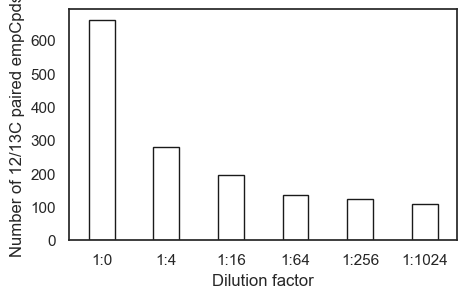

In [19]:
# barplot
dilutions = stats_result.keys()
isopairs = [x['12/13C paired empCpds'] for x in stats_result.values()]
plt.figure(figsize=(5, 3))
sns.set_theme(style="white")
sns.barplot(x=dilutions, y=isopairs, width=0.4, color='w', edgecolor='k')
plt.xticks(ticks=range(len(dilutions)), labels=['1:0', '1:4', '1:16', '1:64', '1:256', '1:1024'])
plt.ylabel('Number of 12/13C paired empCpds')
plt.xlabel('Dilution factor')
plt.savefig('dilution_series_barplot.pdf', dpi=300)

# Conclusion

Overall stats are in the JSON file per input feature table.

The '12/13C paired empCpds' indicates the number of high-confidence detected compounds.

Peak shape (goodness_fitting), cleanness of chromatography (cSelectivity) and SNR are included in asari output feature tables. These are calculated on composite mass tracks but feasible for simple sample if necessary.

One can extend this notebook to other datasets. 